In [227]:
import urllib.request as ur
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [240]:
samples = ['J000092712', 'J000106560', 'TM00016', 'TM00065', 'TM00089', 'TM00090', 'TM00096', 'TM00107', 'TM00137', 'TM00170', 'TM00226', 'TM00231', 'TM00256', 'TM00279', 'TM00314', 'TM00335', 'TM00999', 'TM01571']
#samples = ['J000092712', 'TM00090']

In [241]:
# use data we downloaded one day
jax_rna = pd.read_csv('rna-zscores.csv').set_index('Gene')
jax_strna = pd.read_csv('strna-zscores.csv').set_index('Gene')

In [242]:
# or download now
jax_strna = pd.DataFrame({'Gene': []}).set_index('Gene')
jax_rna = pd.DataFrame({'Gene': []}).set_index('Gene')

for sample in samples:
    page = ur.urlopen(f'http://tumor.informatics.jax.org/mtbwi/pdxDetails.do?modelID={sample}').read().split(b'\r\n')
    for line in page:
        data,count = re.subn(b'\s*expressionData = google.visualization.arrayToDataTable\((.*)\);\s*',b'\g<1>',line)
        if count:
            data = re.sub(b'true',b'True',data)
            data = re.sub(b'false',b'False',data)
            data = re.sub(b"{role:'certainty'}",b'None',data)
            data = re.sub(b'null',b'None',data)
            data = eval(data)
            expr_data = pd.DataFrame(data[1:],columns=data[0]).set_index('Gene')
            counts = expr_data.filter(like='stRNA_Seq')
            if not counts.columns.empty:
                counts.columns=[sample]
                jax_strna = pd.concat([jax_strna, counts],axis = 1)
            else:
                counts = expr_data.filter(like=' RNA_Seq')
                counts.columns=[sample]
                jax_rna = pd.concat([jax_rna,counts],axis = 1) 

In [243]:
# and store eventually
jax_rna.to_csv('rna-zscores.csv')
jax_strna.to_csv('strna-zscores.csv')

In [244]:
# mean values and standard deviations over all JAX samples (kindly provided by JAX)
# those are necessary to invert z-score
meansd_rna = pd.read_csv('rnaseq-meansd.csv',delimiter=';').rename(columns={'gene_symbol_hint':'Gene'}).set_index('Gene').filter(items=['mean','sd'])
meansd_strna = pd.read_csv('strnaseq-meansd.csv',delimiter=';').rename(columns={'gene_symbol_hint':'Gene'}).set_index('Gene').filter(items=['mean','sd'])

In [245]:
# align on common set of genes (there are slight discrepancies in both ways)
meansd_rna = meansd_rna[meansd_rna.index.isin(jax_rna.index)]
jax_rna = jax_rna[jax_rna.index.isin(meansd_rna.index)]
meansd_strna = meansd_strna[meansd_strna.index.isin(jax_strna.index)]
jax_strna = jax_strna[jax_strna.index.isin(meansd_strna.index)]

In [246]:
# put everything in a single table regardless of RNASeq/stRNASeq
jax_expr = pd.concat([jax_rna.mul(meansd_rna['sd'],axis='index').add(meansd_rna['mean'],axis='index'),
    jax_strna.mul(meansd_strna['sd'],axis='index').add(meansd_strna['mean'],axis='index')], axis=1)

In [282]:
# load outputs of our implementation, merge into a single table
galaxy_expr = pd.DataFrame({'Gene': []}).set_index('Gene')

for sample in samples:
    s = pd.read_table(f'galaxy/{sample}')
    s.columns = [ 'Gene','Name',sample ]
    s = s.set_index('Gene').drop('Name',axis=1)
    galaxy_expr = pd.concat([galaxy_expr,s],axis=1)

In [283]:
# align set of genes (we identified far more, mostly zero)
galaxy_expr = galaxy_expr[galaxy_expr.index.isin(jax_expr.index)]
jax_expr = jax_expr[jax_expr.index.isin(galaxy_expr.index)]

In [284]:
# and logtransform; sparse div by zero (zero counts) can be ignored for now
galaxy_expr = np.log2(galaxy_expr)

# neither JAX data are normalized
# galaxy_expr = galaxy_expr.div(galaxy_expr.quantile(q=.75,axis=0),axis=1)

/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


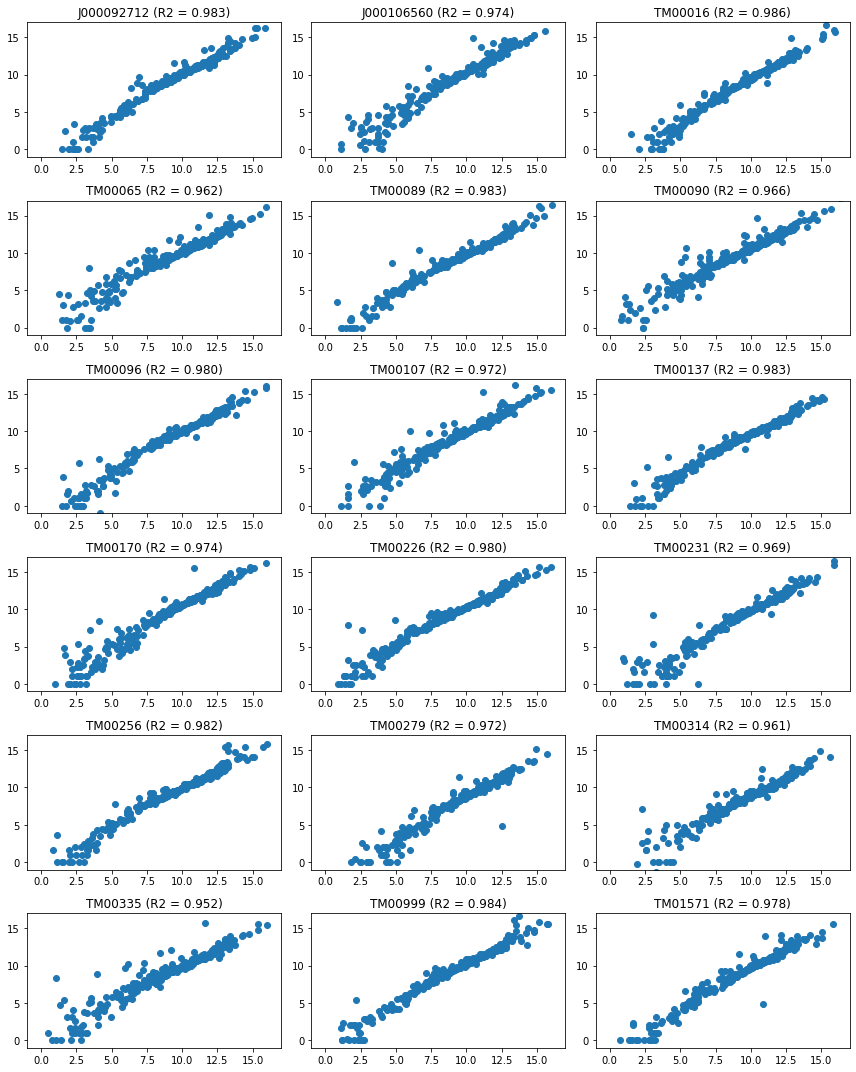

In [288]:
# show everything in scatterplots and compute correlations
fig = plt.figure(figsize=(12,15))
axes = fig.subplots(6,3)
lim = [-1,17]
cr = {}
i=0
for r in axes:
    for p in r:
        sample=samples[i]
        c = pd.concat([jax_expr[sample],galaxy_expr[sample]],axis=1)
        c.columns = ['jax','galaxy']
        c[c == np.inf] = None
        p.scatter(c['jax'],c['galaxy'])
        cr[sample] = c.corr()['jax']['galaxy']
        p.set_title(f"{sample} (R2 = {cr[sample]:.3f})")
        p.set_xlim(lim)
        p.set_ylim(lim)
        i += 1     
        
fig.tight_layout()    
fig.savefig('scatter.pdf')
fig.show()

In [293]:
sorted(cr.values())

[0.9522565214929398,
 0.9610977814900165,
 0.9616188834767829,
 0.9662714143135862,
 0.9685927374731168,
 0.9719161557042558,
 0.9721209001988519,
 0.9738287748590593,
 0.9742196427865674,
 0.9776736516417386,
 0.9797397370050608,
 0.9802459310366946,
 0.982225624797435,
 0.9827471705336768,
 0.9832295787343466,
 0.9833769267186426,
 0.984347594639838,
 0.9858204959616323]